In [14]:
import gymnasium as gym
import numpy as np

class Blackjack(gym.Env):
    def __init__(self,config=None):
        self.current_steps = 0
        self.grid_size = 4
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Discrete(5)
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
    def reset(self, *, seed=None, options=None):
        self._max_episode_steps = 100
        self.current_steps = 0
        self.currentSum=0
        return self.activated_button,{}
    
    def step(self,action):
        self.current_steps+=1
        reward = 1 if action==self.activated_button else 0
        self.activated_button = np.random.randint(0,5)
        return self.activated_button,reward,self.current_steps==self._max_episode_steps,False,{}
        
        
        


In [15]:
from ray.tune.registry import register_env
register_env("pb", pushButton)

In [1]:
import ray
from ray import tune,air
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.callbacks import MemoryTrackingCallbacks
from ray.tune.logger import LoggerCallback
from ray.air import session


class RewardLoggerCallback(LoggerCallback):
    def __init__(self) -> None:
        self.results = []

    def log_trial_result(self, iteration: int, trial, result):
        reward = result  # assuming 'reward' is your reward key
        self.results.append(reward)

callback = RewardLoggerCallback()

stopping_criterion = {"training_iteration": 50}
ray.init(ignore_reinit_error=True, log_to_driver=False)
tuner = tune.Tuner(
    "PPO",
    param_space={
        "env": "Blackjack-v1",
        "framework": "torch",
        "num_gpus": 0,
        "num_workers":8,
        "should_checkpoint": True,
    },
    run_config=air.RunConfig(
        stop=stopping_criterion,callbacks=[callback],
        checkpoint_config=air.CheckpointConfig(checkpoint_frequency=1),
        ),
)
results = tuner.fit()
ray.shutdown()

2023-08-06 16:25:42,242	INFO worker.py:1636 -- Started a local Ray instance.
2023-08-06 16:25:42,810	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-06 16:25:42,811	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-06 16:25:42,872	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/maml/maml.py` has been deprecated. Use `rllib_contrib/maml/` instead. This will raise an error in the future!
2023-08-06 16:25:42,889	WARNING syncer.py:222 -- You are using remote storage, but you don't have `fsspec` installed. This can lead to inefficient syncing behavior. To avoid this, install fsspec with `pip install fsspec`. Depending on your remote storage provider, consider installing the respective fsspec-package (see https:

2023-08-06 16:25:42,910	WARNING algorithm_config.py:643 -- Cannot create PPOConfig from given `config_dict`! Property should_checkpoint not supported.


Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_total,training_iteration,trial_id
PPO_Blackjack-v1_d56f7_00000,200000,"{'ObsPreprocessorConnector_ms': 0.012632656606620364, 'StateBufferConnector_ms': 0.005814930939838051, 'ViewRequirementAgentConnector_ms': 0.051982288229656434}","{'num_env_steps_sampled': 200000, 'num_env_steps_trained': 200000, 'num_agent_steps_sampled': 200000, 'num_agent_steps_trained': 200000}",{},2023-08-06_16-28-33,True,1.52441,{},1,-0.0537757,-1,2622,137843,michaelmbp.local,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.0606454118605584, 'cur_kl_coeff': 1.0477378964424136e-10, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 0.6969371680610923, 'policy_loss': -0.0009732426064068912, 'vf_loss': 0.6979104116398801, 'vf_explained_var': 0.21456445205596186, 'kl': 0.0069798803968616745, 'entropy': 0.04857421345728379, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 46035.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 200000, 'num_env_steps_trained': 200000, 'num_agent_steps_sampled': 200000, 'num_agent_steps_trained': 200000}",50,127.0.0.1,200000,200000,200000,4000,1284.62,200000,4000,1284.62,0,8,0,0,4000,"{'cpu_util_percent': 21.55, 'ram_util_percent': 61.0}",61854,{},{},{},"{'mean_raw_obs_processing_ms': 0.433058383759585, 'mean_inference_ms': 0.45446753150970715, 'mean_action_processing_ms': 0.053418147073975936, 'mean_env_wait_ms': 0.031227094692883164, 'mean_env_render_ms': 0.0}",163.982,3.13118,163.982,"{'training_iteration_time_ms': 3211.837, 'sample_time_ms': 512.202, 'load_time_ms': 0.561, 'load_throughput': 7133473.362, 'learn_time_ms': 2693.661, 'learn_throughput': 1484.968, 'synch_weights_time_ms': 4.668}",1691310513,200000,50,d56f7_00000


2023-08-06 16:28:33,814	INFO tune.py:1111 -- Total run time: 170.92 seconds (170.60 seconds for the tuning loop).


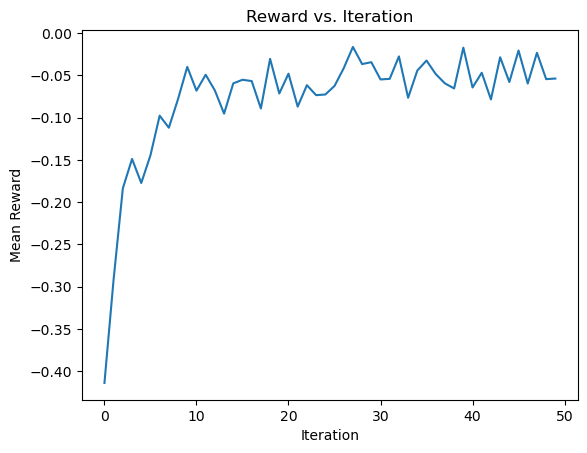

In [2]:
import matplotlib.pyplot as plt
rewards = [i["episode_reward_mean"] for i in callback.results]

plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward vs. Iteration")
plt.show()

In [3]:
# Get the best result
best_result = results.get_best_result()

# Get the best checkpoint
best_checkpoint = best_result.checkpoint

In [4]:
best_checkpoint

Checkpoint(local_path=/Users/spacefarers/ray_results/PPO/PPO_Blackjack-v1_d56f7_00000_0_2023-08-06_16-25-42/checkpoint_000050)

In [19]:
from ray.rllib.algorithms.algorithm import Algorithm
register_env("pb", pushButton)
algo = Algorithm.from_checkpoint(best_checkpoint)

/Users/spacefarers/mambaforge/envs/rl/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/spacefarers/mambaforge/envs/rl/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/spacefarers/mambaforge/envs/rl/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: T

In [32]:
from time import sleep
env = pushButton()
obs = env.reset()[0]
progression = []
done = False

In [33]:
obs

0

In [34]:
from IPython.display import clear_output
lastObs=obs
while not done:
    action = algo.compute_single_action(obs)
    obs, reward, done, info,ads = env.step(action)
    print(f"action: {action}")
    print(f"obs: {obs}")
    print(f"reward: {reward}")
    if lastObs==action:
        print("WIN")
    lastObs=obs
    sleep(1)
    clear_output(True)
    # progression.append(obs)

action: 4
obs: 1
reward: 1
WIN


KeyboardInterrupt: 